在这个例子中，我们将使用 **Metropolis-Hastings 算法** 来求解线性回归模型的参数 $ \beta $，其中模型是 $ Y = X \beta $。我们假设 $ Y $ 是因变量，$ X $ 是自变量矩阵，$ \beta $ 是需要估计的参数向量。

### 1. **问题设定**

我们假设线性回归模型的形式为：
$$
Y = X \beta + \epsilon
$$
其中：
- $ Y $ 是因变量向量（大小为 $ n \times 1 $）。
- $ X $ 是自变量矩阵（大小为 $ n \times p $，其中 $ p $ 是自变量的个数）。
- $ \beta $ 是待估计的参数向量（大小为 $ p \times 1 $）。
- $ \epsilon $ 是误差项，假设 $ \epsilon \sim N(0, \sigma^2) $，即误差项服从正态分布。

我们要使用 Metropolis-Hastings 算法对 $ \beta $ 进行贝叶斯推断，即从后验分布 $ p(\beta | X, Y) $ 中抽样，从而获得 $ \beta $ 的估计值。

### 2. **贝叶斯推断框架**

贝叶斯推断的目标是求解参数 $ \beta $ 的后验分布 $ p(\beta | X, Y) $。根据贝叶斯定理，后验分布可以写作：
$$
p(\beta | X, Y) \propto p(Y | X, \beta) p(\beta)
$$
其中：
- $ p(Y | X, \beta) $ 是**似然函数**，表示给定参数 $ \beta $ 后观测到 $ Y $ 的概率。
- $ p(\beta) $ 是**先验分布**，表示在看到数据之前我们对参数 $ \beta $ 的信念。

我们假设：
- 似然函数 $ p(Y | X, \beta) $ 服从正态分布：
  $$
  p(Y | X, \beta) = \frac{1}{(2\pi \sigma^2)^{n/2}} \exp\left(-\frac{1}{2\sigma^2} (Y - X \beta)^T (Y - X \beta)\right)
  $$
- 先验分布 $ p(\beta) $ 为标准正态分布：
  $$
  p(\beta) = \frac{1}{(2\pi)^{p/2}} \exp\left(-\frac{1}{2} \beta^T \beta\right)
  $$

因此，后验分布的未归一化形式为：
$$
p(\beta | X, Y) \propto \exp\left(-\frac{1}{2\sigma^2} (Y - X \beta)^T (Y - X \beta)\right) \cdot \exp\left(-\frac{1}{2} \beta^T \beta\right)
$$

我们将使用 Metropolis-Hastings 算法从这个后验分布中抽样，得到 $ \beta $ 的估计值。

### 3. **Metropolis-Hastings 算法的步骤**

Metropolis-Hastings 算法的步骤如下：

1. **选择初始参数 $ \beta_0 $**：初始化参数向量 $ \beta_0 $。

2. **选择建议分布 $ q(\beta^* | \beta_t) $**：我们可以使用对称的建议分布，例如正态分布 $ q(\beta^* | \beta_t) = N(\beta_t, \sigma_q^2 I) $，其中 $ \sigma_q $ 是建议分布的标准差，$ I $ 是单位矩阵。

3. **计算接受概率**：
   $$
   \alpha(\beta_t, \beta^*) = \min\left(1, \frac{p(\beta^* | X, Y)}{p(\beta_t | X, Y)}\right)
   $$
   由于先验和似然函数的对数形式比较简单，因此我们可以使用对数来简化计算。接受概率可以表示为：
   $$
   \log\alpha(\beta_t, \beta^*) = \min\left(0, \log p(\beta^* | X, Y) - \log p(\beta_t | X, Y)\right)
   $$
   其中 $ \log p(\beta | X, Y) $ 可以表示为：
   $$
   \log p(\beta | X, Y) = -\frac{1}{2\sigma^2} (Y - X \beta)^T (Y - X \beta) - \frac{1}{2} \beta^T \beta
   $$

4. **接受或拒绝候选样本**：生成一个均匀分布 $ U(0, 1) $ 中的随机数 $ u $。如果 $ u \leq \alpha(\beta_t, \beta^*) $，则接受 $ \beta^* $ 作为新的状态 $ \beta_{t+1} $；否则，保留当前状态 $ \beta_{t+1} = \beta_t $。

5. **重复采样**：重复上述步骤，直到生成足够多的样本。

### 4. **Python 实现**

我们可以用 Python 实现这个过程。下面是基于 Metropolis-Hastings 算法的线性回归参数 $ \beta $ 的求解过程：

```python
import numpy as np
import matplotlib.pyplot as plt

# 定义似然函数和先验分布的对数
def log_likelihood(beta, X, Y, sigma2):
    error = Y - X @ beta
    return -0.5 * (1 / sigma2) * (error.T @ error)

def log_prior(beta):
    return -0.5 * np.dot(beta, beta)

def log_posterior(beta, X, Y, sigma2):
    return log_likelihood(beta, X, Y, sigma2) + log_prior(beta)

# Metropolis-Hastings 算法实现
def metropolis_hastings(X, Y, num_samples, sigma2, proposal_std, initial_beta):
    samples = []
    beta_current = initial_beta
    n, p = X.shape

    for i in range(num_samples):
        # 从建议分布中生成候选样本
        beta_proposed = np.random.normal(beta_current, proposal_std, size=p)
        
        # 计算当前状态和候选状态的后验对数值
        log_posterior_current = log_posterior(beta_current, X, Y, sigma2)
        log_posterior_proposed = log_posterior(beta_proposed, X, Y, sigma2)
        
        # 计算接受概率
        log_acceptance_ratio = log_posterior_proposed - log_posterior_current
        acceptance_prob = np.min([1, np.exp(log_acceptance_ratio)])
        
        # 生成均匀分布随机数判断是否接受
        u = np.random.uniform(0, 1)
        if u < acceptance_prob:
            beta_current = beta_proposed
        
        samples.append(beta_current)

    return np.array(samples)

# 数据生成
np.random.seed(42)
n, p = 100, 3
X = np.random.normal(0, 1, (n, p))
true_beta = np.array([0.5, -1, 2])
sigma2 = 0.1
Y = X @ true_beta + np.random.normal(0, np.sqrt(sigma2), n)

# Metropolis-Hastings 采样
num_samples = 10000
proposal_std = 0.1
initial_beta = np.zeros(p)
samples = metropolis_hastings(X, Y, num_samples, sigma2, proposal_std, initial_beta)

# 输出每个参数的估计值和真实值
estimated_beta = np.mean(samples, axis=0)
print("Estimated β:", estimated_beta)
print("True β:", true_beta)

# 提取每个参数的样本并绘制直方图
plt.figure(figsize=(20, 5))
# 计算需要多少列，这里假设每行显示4个参数的直方图
columns = 4
rows = (p + columns - 1) // columns  # 计算需要多少行

# 创建子图
for i in range(p):
    plt.subplot(rows, columns, i + 1)  # 创建子图，确定行数和列数
    plt.hist(samples[:, i], bins=50, density=True, alpha=0.6, color='g')
    plt.axvline(true_beta[i], color='r', linestyle='--', label=f'True β[{i}]')
    plt.title(f'Posterior distribution of β[{i}]')
    plt.xlabel(f'β[{i}]')
    plt.ylabel('Density')
    plt.legend()

# 调整子图之间的间距
plt.tight_layout()
plt.show()
```

### 5. **结果解释**

- 在这个代码中，`metropolis_hastings` 函数通过 Metropolis-Hastings 算法从后验分布 $ p(\beta | X, Y) $ 中抽取样本。我们使用了对称的正态分布作为建议分布。
- 在采样过程中，接受概率 $ \alpha(\beta_t, \beta^*) $ 通过目标分布（后验分布）的对数值差异计算。
- 采样结束后，我们绘制了

每个参数 $ \beta[i] $ 的后验分布的直方图，并与真实值进行对比。

通过这个实现，我们可以用 Metropolis-Hastings 算法有效地对线性回归模型的参数 $ \beta $ 进行贝叶斯推断，并估计其后验分布。

### 6. **总结**

Metropolis-Hastings 算法是一种强大的 MCMC 方法，可以从复杂的后验分布中进行采样。在这个例子中，我们使用了 Metropolis-Hastings 算法来估计线性回归模型的参数 $ \beta $，通过从后验分布 $ p(\beta | X, Y) $ 中生成样本，我们可以对 $ \beta $ 的不确定性进行建模。

Estimated β: [ 0.47394358 -1.0165367   1.96013744]
True β: [ 0.5 -1.   2. ]


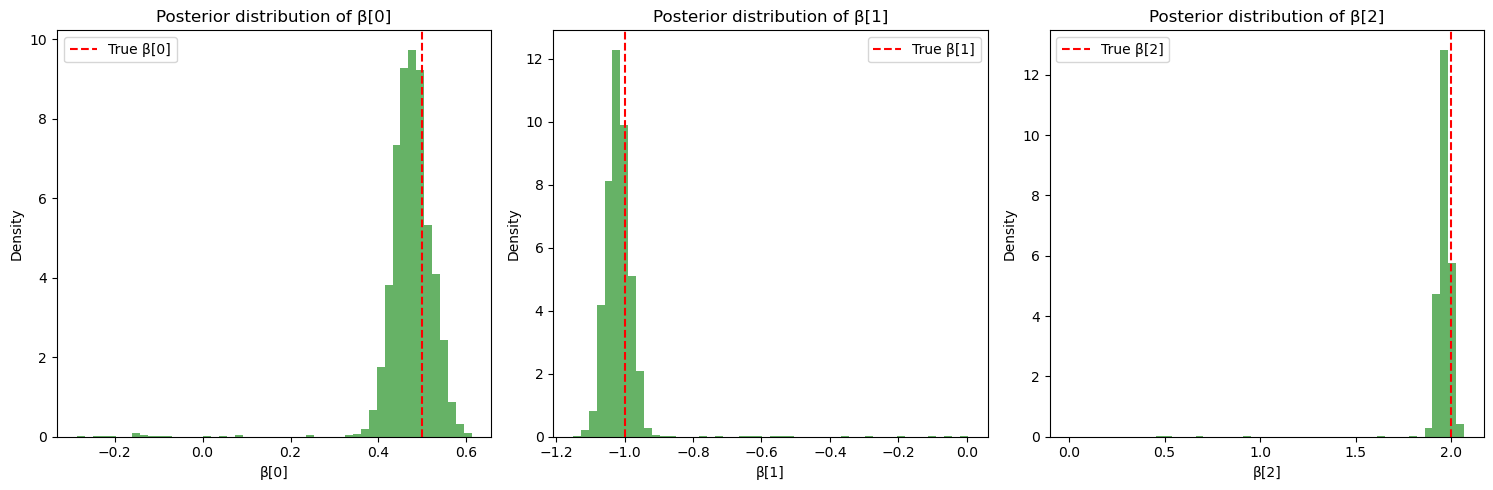

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 定义似然函数和先验分布的对数
def log_likelihood(beta, X, Y, sigma2):
    error = Y - X @ beta
    return -0.5 * (1 / sigma2) * (error.T @ error)

def log_prior(beta):
    return -0.5 * np.dot(beta, beta)

def log_posterior(beta, X, Y, sigma2):
    return log_likelihood(beta, X, Y, sigma2) + log_prior(beta)

# Metropolis-Hastings 算法实现
def metropolis_hastings(X, Y, num_samples, sigma2, proposal_std, initial_beta):
    samples = []
    beta_current = initial_beta
    n, p = X.shape

    for i in range(num_samples):
        # 从建议分布中生成候选样本
        beta_proposed = np.random.normal(beta_current, proposal_std, size=p)
        
        # 计算当前状态和候选状态的后验对数值
        log_posterior_current = log_posterior(beta_current, X, Y, sigma2)
        log_posterior_proposed = log_posterior(beta_proposed, X, Y, sigma2)
        
        # 计算接受概率
        log_acceptance_ratio = log_posterior_proposed - log_posterior_current
        acceptance_prob = np.min([1, np.exp(log_acceptance_ratio)])
        
        # 生成均匀分布随机数判断是否接受
        u = np.random.uniform(0, 1)
        if u < acceptance_prob:
            beta_current = beta_proposed
        
        samples.append(beta_current)

    return np.array(samples)

# 数据生成
np.random.seed(42)
n, p = 100, 3
X = np.random.normal(0, 1, (n, p))
true_beta = np.array([0.5, -1, 2])
sigma2 = 0.1
Y = X @ true_beta + np.random.normal(0, np.sqrt(sigma2), n)

# Metropolis-Hastings 采样
num_samples = 10000
proposal_std = 0.1
initial_beta = np.zeros(p)
samples = metropolis_hastings(X, Y, num_samples, sigma2, proposal_std, initial_beta)

# 输出每个参数的估计值和真实值
estimated_beta = np.mean(samples, axis=0)
print("Estimated β:", estimated_beta)
print("True β:", true_beta)


# 计算需要多少列，这里假设每行显示4个参数的直方图
columns = 4
rows = (p + columns - 1) // columns  # 计算需要多少行
# 提取每个参数的样本并绘制直方图
plt.figure(figsize=(20, 5))
# 创建子图
for i in range(p):
    plt.subplot(rows, columns, i + 1)  # 创建子图，确定行数和列数
    plt.hist(samples[:, i], bins=50, density=True, alpha=0.6, color='g')
    plt.axvline(true_beta[i], color='r', linestyle='--', label=f'True β[{i}]')
    plt.title(f'Posterior distribution of β[{i}]')
    plt.xlabel(f'β[{i}]')
    plt.ylabel('Density')
    plt.legend()

# 调整子图之间的间距
plt.tight_layout()
plt.show()